# Categorical Variable - Pipeline from Metadata

In [1]:
import pandas as pd
import numpy as np
import importlib

import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append(os.getcwd() + "\\..\\src")
#sys.path.append('c:/Users/User/Documents/User/Work/Admiral/Pipeline_Builder/pipelineconstruction/src')

## Investigating the Input Data

Load the data we will be using as an example. This is house price data with various numeric and categorical factors. We don't particularly care about the response here as this document is on factor pre-processing. An example of the data is shown below

In [2]:
hp_train = pd.read_csv("..\\data\\raw\\HousePrices_train.csv")
hp_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Numeric Encoding

The following code will be useful in Numeric Encodings 

In [3]:
#Read in metadata sheet
control_sheet = pd.read_csv("../controls/california_housing_control_sheet.csv")

for this notebook we only care about the categorical columns. We will therefore drop the numeric variables to keep the dataset smaller and simpler

In [4]:
hp_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [5]:
hp_num_train = hp_train.select_dtypes(include=["float64", "int64"])
hp_num_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


We will now plot the count of each of the first 9 (again to keep this small and simple) numeric variables. Starting with making the dataset long

In [6]:
hp_num_long = pd.melt(hp_num_train.iloc[:,0:10], id_vars=['Id'])

and then using seaborn to plot the results

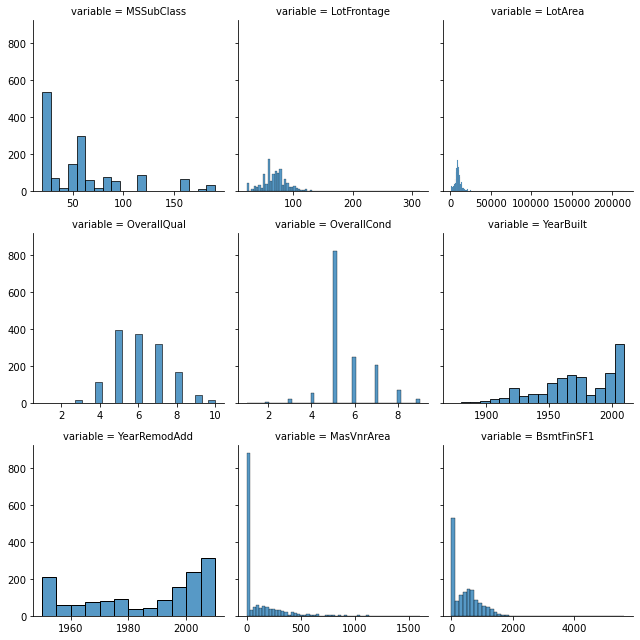

In [7]:
grid = sns.FacetGrid(hp_num_long, col_wrap=3, col="variable", sharex=False)
grid.map_dataframe(sns.histplot, x="value")

We can see some factors such as LotArea have some outliers. Some columns such as OverallCond are intergers others aren't. We can also see that some columns such as street have many unknowns (which aren't plotted)

We will now subset this dataset into just these variables so the example is kept smaller

In [8]:
hp_num_train_work = hp_num_train.iloc[:,0:10]

## Building the Metadata

We will start by showing the example metadata for this problem. Normally the metadata will be built iteratively by looking at the input to and output from the pipeline

In [9]:
control_sheet = pd.read_csv("..//controls/Housing_Numeric_ControlSheet.csv")
control_sheet

,FeatureName,TransformedName,Include,Raw,Numeric,Numeric_Unk_Min,Numeric_Cap_Min,Numeric_Cap_Max,Numeric_Unk_Max,Missing_Values,Shadow_Col,Impute_Strategy,Impute_Value
0,Id,Id,N,Y,Y,NaN,NaN,NaN,NaN,-1; -2,N,median,NaN
1,MSSubClass,MSSubClass,Y,Y,Y,19.0,NaN,NaN,191.0,NaN,Y,median,NaN
2,LotFrontage,LotFrontage,Y,Y,Y,0.0,10.0,175.0,1000.0,NaN,Y,median,NaN
3,LotArea,LotArea,Y,Y,Y,0.0,10.0,30000.0,NaN,NaN,Y,constant,10.0
4,OverallQual,OverallQual,Y,Y,Y,0.0,NaN,NaN,11.0,NaN,Y,median,NaN
5,OverallCond,OverallCond,Y,Y,Y,0.0,NaN,NaN,11.0,NaN,Y,median,NaN
6,YearBuilt,YearBuilt,Y,Y,Y,1500.0,1800.0,2020.0,2020.0,NaN,Y,median,NaN
7,YearRemodAdd,YearRemodAdd,Y,Y,Y,1500.0,1800.0,2020.0,2020.0,NaN,Y,median,NaN
8,MasVnrArea,MasVnrArea,Y,Y,Y,0.0,0.0,1000.0,NaN,0,Y,constant,0.0
9,BsmtFinSF1,BsmtFinSF1,Y,Y,Y,0.0,0.0,3000.0,10000.0,0,Y,constant,0.0


## Building the Column Transformer Pipeline

We will then import sklearn tools and our custom transformations

These are standard sklearn tools

In [10]:
# Import standard functions
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import MissingIndicator

and importing the custom functions

In [11]:
# Import custom functions
from transformers.IdentifyUnknowns import IdentifyUnknowns
from transformers.NumericCapping import NumericCapping

from transformers.names_from_ColumnTransformer import names_from_ColumnTransformer

importlib.reload(sys.modules[IdentifyUnknowns.__module__])
importlib.reload(sys.modules[NumericCapping.__module__])

<module 'transformers.NumericCapping' from 'c:\\Users\\User\\Documents\\User\\Work\\Admiral\\Pipeline_Builder\\pipelineconstruction\\notebooks\\..\\src\\transformers\\NumericCapping.py'>

In [12]:
from construction.BuildNumericPipeline import BuildNumericPipeline
importlib.reload(sys.modules[BuildNumericPipeline.__module__])

<module 'construction.BuildNumericPipeline' from 'c:\\Users\\User\\Documents\\User\\Work\\Admiral\\Pipeline_Builder\\pipelineconstruction\\notebooks\\..\\src\\construction\\BuildNumericPipeline.py'>

We can then call our pipeline former using the metadata

In [13]:
col_transformers_list = BuildNumericPipeline(control_sheet)

We now have a list of tuples in the form of a sklearn column transformation object. Which looks something like this

In [14]:
col_transformers_list

[('MSSubClass',
  FeatureUnion(transformer_list=[('MSSubClass',
                                  Pipeline(steps=[('unk_levels',
                                                   IdentifyUnknowns(unk_levels=[[-1.0,
                                                                                 -2.0]])),
                                                  ('capping',
                                                   NumericCapping(cap_max=[nan],
                                                                  cap_min=[nan],
                                                                  unk_max=[191.0],
                                                                  unk_min=[19.0])),
                                                  ('impute',
                                                   SimpleImputer(fill_value=nan,
                                                                 strategy='median'))])),
                                 ('MSSubClass_NA',
                    

looking at a single column to keep this simple we find the below. Notice that the second object (indexed by 1) is a Pipeline object which contains all the transformations

In [15]:
col_transformers_list[0]

('MSSubClass',
 FeatureUnion(transformer_list=[('MSSubClass',
                                 Pipeline(steps=[('unk_levels',
                                                  IdentifyUnknowns(unk_levels=[[-1.0,
                                                                                -2.0]])),
                                                 ('capping',
                                                  NumericCapping(cap_max=[nan],
                                                                 cap_min=[nan],
                                                                 unk_max=[191.0],
                                                                 unk_min=[19.0])),
                                                 ('impute',
                                                  SimpleImputer(fill_value=nan,
                                                                strategy='median'))])),
                                ('MSSubClass_NA',
                                 P

Each of these object can be applied on its own (see below) rather than the whole column transformer

In [16]:
col_transformers_list[6][1].fit_transform(hp_num_train_work[["MSSubClass"]])

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

We can now build the column transformer object and train it on the data (normally this would be the test set). 

In [17]:
col_tran = ColumnTransformer(col_transformers_list)
X_t = col_tran.fit_transform(hp_num_train_work)

turning the transformed matrix into a pandas dataframe and showing to top few results gives the below output where we can see that all columns are now numeric (as needed)

In [18]:
X_t_df = pd.DataFrame(X_t, columns=names_from_ColumnTransformer(col_tran))
X_t_df.head()

,MSSubClass,MSSubClass_NA,LotFrontage,LotFrontage_NA,LotArea,LotArea_NA,OverallQual,OverallQual_NA,OverallCond,OverallCond_NA,YearBuilt,YearBuilt_NA,YearRemodAdd,YearRemodAdd_NA,MasVnrArea,MasVnrArea_NA,BsmtFinSF1,BsmtFinSF1_NA
0,60.0,0.0,65.0,0.0,8450.0,0.0,7.0,0.0,5.0,0.0,2003.0,0.0,2003.0,0.0,196.0,0.0,706.0,0.0
1,20.0,0.0,80.0,0.0,9600.0,0.0,6.0,0.0,8.0,0.0,1976.0,0.0,1976.0,0.0,0.0,0.0,978.0,0.0
2,60.0,0.0,68.0,0.0,11250.0,0.0,7.0,0.0,5.0,0.0,2001.0,0.0,2002.0,0.0,162.0,0.0,486.0,0.0
3,70.0,0.0,60.0,0.0,9550.0,0.0,7.0,0.0,5.0,0.0,1915.0,0.0,1970.0,0.0,0.0,0.0,216.0,0.0
4,60.0,0.0,84.0,0.0,14260.0,0.0,8.0,0.0,5.0,0.0,2000.0,0.0,2000.0,0.0,350.0,0.0,655.0,0.0


To see the distributions of each factor we can do some plotting with seaborn to show the factor distributions

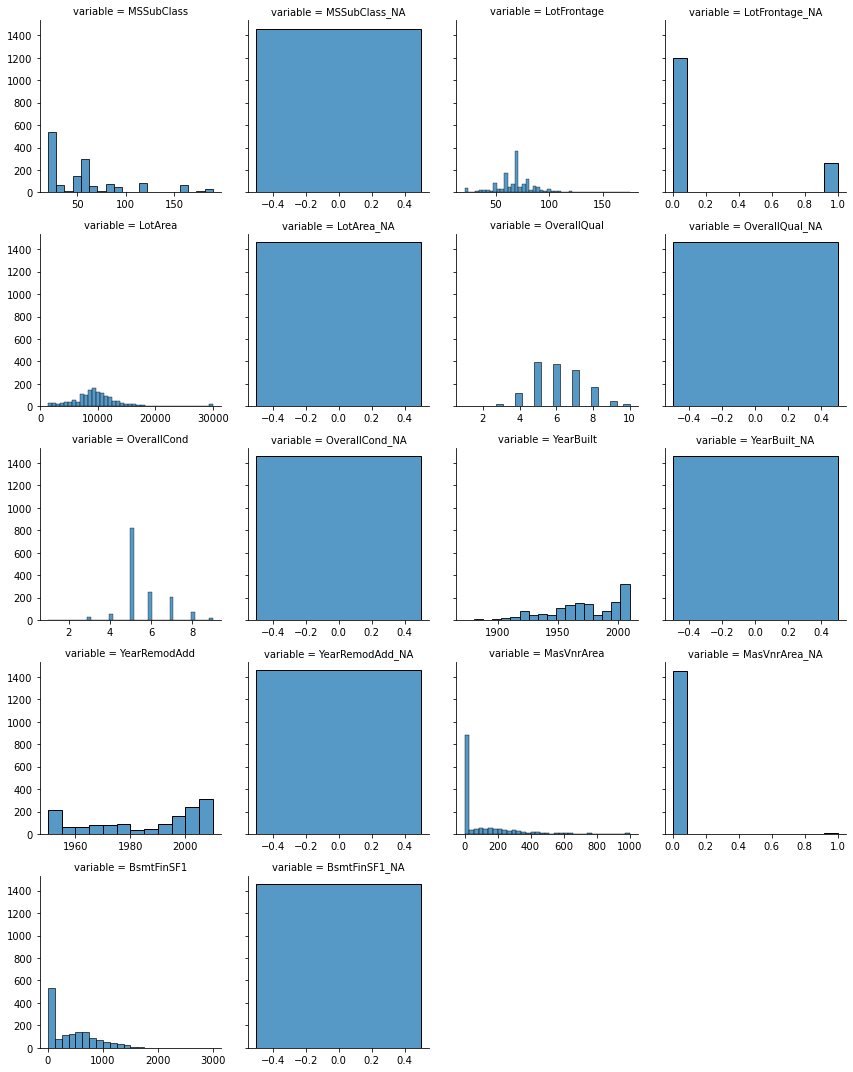

In [19]:
X_t_id = pd.concat([hp_train["Id"], X_t_df ], axis=1)
X_t_long = pd.melt(X_t_id, id_vars=['Id'])
grid = sns.FacetGrid(X_t_long, col_wrap=4, col="variable", sharex=False)
grid.map_dataframe(sns.histplot, x="value")

The columns with the suffixes "_NA" are the shadow columns showing where unknowns are.

## New Data

The real power of this approach comes when we have new data. This can be the test data (or live data we only receive after deployment). We want (in the case of test) or need (in the case of live data) for the train transformations to be blind to the new data. We also need the transformations on the new data to be identical to the training data. With this approach can do this very easily.

read in the new data

In [20]:
hp_test = pd.read_csv("..\\data\\raw\\HousePrices_test.csv")
hp_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


it can now be transformed as simply as

In [21]:
hp_num_test_work = hp_test.reindex(columns=hp_num_train_work.columns)

X_test_t = col_tran.transform(hp_num_test_work)
X_test_t_df = pd.DataFrame(X_test_t, columns=names_from_ColumnTransformer(col_tran))
X_test_t_df.head()

,MSSubClass,MSSubClass_NA,LotFrontage,LotFrontage_NA,LotArea,LotArea_NA,OverallQual,OverallQual_NA,OverallCond,OverallCond_NA,YearBuilt,YearBuilt_NA,YearRemodAdd,YearRemodAdd_NA,MasVnrArea,MasVnrArea_NA,BsmtFinSF1,BsmtFinSF1_NA
0,20.0,0.0,80.0,0.0,11622.0,0.0,5.0,0.0,6.0,0.0,1961.0,0.0,1961.0,0.0,0.0,0.0,468.0,0.0
1,20.0,0.0,81.0,0.0,14267.0,0.0,6.0,0.0,6.0,0.0,1958.0,0.0,1958.0,0.0,108.0,0.0,923.0,0.0
2,60.0,0.0,74.0,0.0,13830.0,0.0,5.0,0.0,5.0,0.0,1997.0,0.0,1998.0,0.0,0.0,0.0,791.0,0.0
3,60.0,0.0,78.0,0.0,9978.0,0.0,6.0,0.0,6.0,0.0,1998.0,0.0,1998.0,0.0,20.0,0.0,602.0,0.0
4,120.0,0.0,43.0,0.0,5005.0,0.0,8.0,0.0,5.0,0.0,1992.0,0.0,1992.0,0.0,0.0,0.0,263.0,0.0


and now our model can predict on this new dataset.

We could (and would) place our transformer into a pipeline with our model and it would be called whenever we used the .predict function of the model. This would mean we could go directly from the new data to the predictions and never need to know about the transformations.